In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msn
import dexplot as dxp

In [2]:
import numpy as np
from scipy.stats import spearmanr

In [3]:

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb

In [4]:
train=pd.read_csv("training_set_VU_DM.csv")
#test=pd.read_csv("test_set_VU_DM.csv")


In [5]:
to_drop= ['comp1_rate',
'comp1_inv',
'comp1_rate_percent_diff',
'comp2_rate',
'comp2_inv',
'comp2_rate_percent_diff',
'comp3_rate',
'comp3_inv',
'comp3_rate_percent_diff',
'comp4_rate',
'comp4_inv',
'comp4_rate_percent_diff',
'comp5_rate',
'comp5_inv',
'comp5_rate_percent_diff',
'comp6_rate',
'comp6_inv',
'comp6_rate_percent_diff',
'comp7_rate',
'comp7_inv',
'comp7_rate_percent_diff',
'comp8_rate',
'comp8_inv',
'comp8_rate_percent_diff'

]

#train['outcome'] = pd.Series(train['booking_bool']> 0, 500 + train['position'] , train['click_bool']> 0, 100 +train['position'] , 0 + train['position'] )

conditions = [
    #(train['booking_bool']> 0),
    (train['click_bool']> 0)
]

#choices = [500+(40 - train['position']) ,100+(40 - train['position'])]
#train['outcome'] = np.select(conditions, choices, default=(40 - train['position'])

#choices = [2 ,1]
choices = [1]
train['outcome'] = np.select(conditions, choices, default=0)

train = train.drop(to_drop,  axis=1)#.sample(frac=0.2, replace=True, random_state=1)
#test_reduced  = test.iloc[: , :N].sample(frac=0.33, replace=True, random_state=1)
train = train[train.price_usd < 3001]

In [45]:
train['price_bin'] = pd.qcut(train['price_usd'], q=80, precision=0)
train['mean_price_bin_star'] = train.groupby('price_bin')['prop_starrating'].transform('mean')
train['mean_price_bin_review'] = train.groupby('price_bin')['prop_review_score'].transform('mean')
train['prop_review_score'] = train['prop_review_score'].fillna(0)
train.loc[train.prop_review_score == 0, "prop_review_score"] = train.mean_price_bin_review
train.loc[train.prop_starrating == 0, "prop_starrating"] = train.mean_price_bin_star



In [46]:
train['max_price'] = train.groupby('srch_id')['price_usd'].transform('max') 
train['min_price'] = train.groupby('srch_id')['price_usd'].transform('min') 
train['mean_price'] = train.groupby('srch_id')['price_usd'].transform('mean') 
train['diff_max_price'] =(train['max_price'] -train['price_usd']) / train['price_usd']
train['diff_min_price'] = (train['min_price'] - train['price_usd'])/ train['price_usd']
train['diff_min_price'] = train['diff_min_price'].replace(np.nan, 0)
train['diff_mean_price'] = (train['mean_price'] - train['price_usd']) / train['price_usd']
train['price_review_value'] =  train['prop_review_score'] /train['mean_price_bin_review'] 


In [47]:
train['hotel_click_prob'] = train.groupby('prop_id')['click_bool'].transform('sum') / train.groupby('prop_id')['click_bool'].transform('count')
train['hotel_click_prob'] = train.groupby('prop_id')['click_bool'].transform('sum') / train.groupby('prop_id')['click_bool'].transform('count')
train['hotel_show_prob'] =  train.groupby('prop_id')['prop_id'].transform('count') / train.groupby('srch_id')['prop_id'].transform('count')
#pd.crosstab(train.hotel_click_prob, train.prop_id, dropna=False)



In [48]:
train['hotel_buy_prob'] = train.groupby('prop_id')['booking_bool'].transform('sum') / train.groupby('prop_id')['booking_bool'].transform('count')
#pd.crosstab(train.hotel_buy_prob, train.prop_id, dropna=False)


In [49]:
train['outcome'].value_counts()


0    4732797
1     221696
Name: outcome, dtype: int64

In [50]:
train_reduced = train.groupby('outcome')
train_reduced = pd.DataFrame(train_reduced.apply(lambda x: x.sample(train_reduced.size().min()).reset_index(drop=True)))

In [51]:
# conditions = [
#     (train['booking_bool']> 0),
#     (train['click_bool']> 0)
# ]

# choices = [500+train['position'],100+train['position'], train['position']]
# train['outcome'] = np.select(conditions, choices, default=train['position'])

In [52]:
train_reduced.isnull().mean() * 100

srch_id                         0.000000
date_time                       0.000000
site_id                         0.000000
visitor_location_country_id     0.000000
visitor_hist_starrating        95.001940
visitor_hist_adr_usd           94.976905
prop_country_id                 0.000000
prop_id                         0.000000
prop_starrating                 0.000000
prop_review_score               0.000000
prop_brand_bool                 0.000000
prop_location_score1            0.000000
prop_location_score2           17.219977
prop_log_historical_price       0.000000
position                        0.000000
price_usd                       0.000000
promotion_flag                  0.000000
srch_destination_id             0.000000
srch_length_of_stay             0.000000
srch_booking_window             0.000000
srch_adults_count               0.000000
srch_children_count             0.000000
srch_room_count                 0.000000
srch_saturday_night_bool        0.000000
srch_query_affin

<AxesSubplot:>

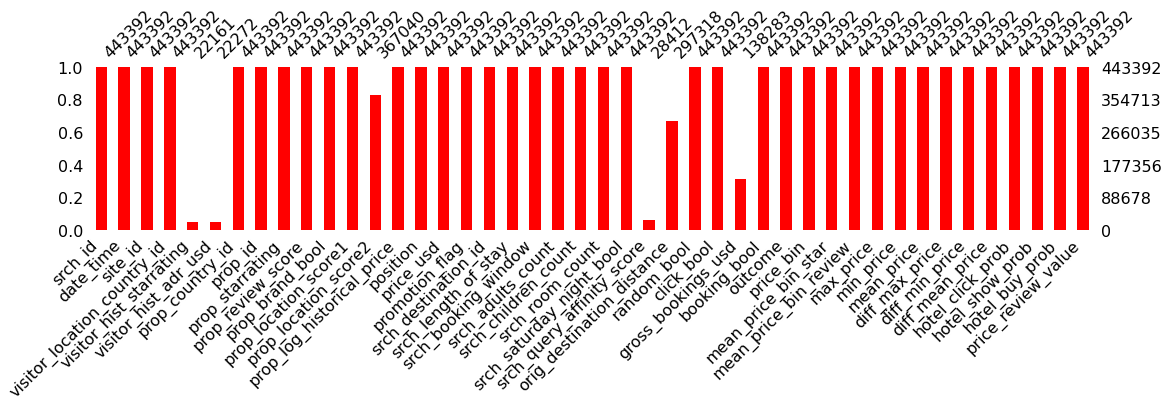

In [53]:
msn.bar(train_reduced,figsize=(18,3), color='red')

<AxesSubplot:>

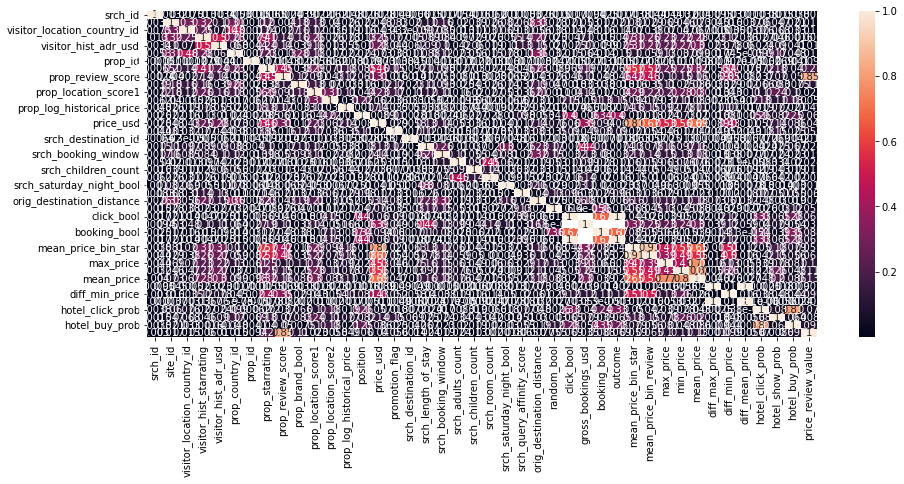

In [54]:
plt.figure(figsize=(15, 6))
sns.heatmap(train_reduced.corr().abs(),  annot=True)

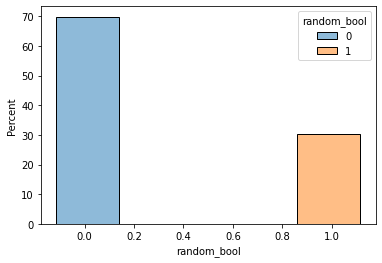

In [55]:
#ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'], multiple="dodge", 
#train_reduced = train_reduced.reset_index()
ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'] ,
                  stat = 'percent', shrink =10, common_norm=True)

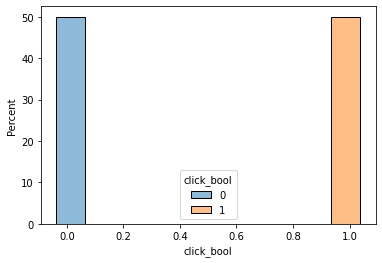

In [56]:
#ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'], multiple="dodge", 
#train_reduced = train_reduced.reset_index()
ax = sns.histplot(x = train_reduced['click_bool'], hue=train_reduced['click_bool'] ,
                  stat = 'percent', shrink =4,common_norm=True)

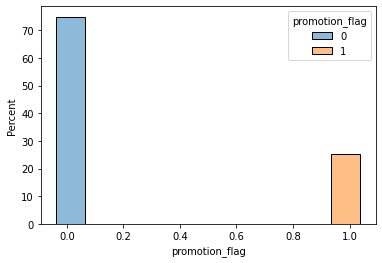

In [57]:
#ax = sns.histplot(x = train_reduced['random_bool'], hue=train_reduced['random_bool'], multiple="dodge", 
#train_reduced = train_reduced.reset_index()
ax = sns.histplot(x = train_reduced['promotion_flag'], hue=train_reduced['promotion_flag'] ,
                  stat = 'percent', shrink =4,common_norm=True)

In [58]:
# train_reduced['bought_flag'] = np.where(train_reduced['gross_bookings_usd']> 0, 1, 0)

# ax = sns.histplot(x = train_reduced['bought_flag'], hue=train_reduced['bought_flag'] ,
#                   stat = 'percent', shrink =4,common_norm=True)


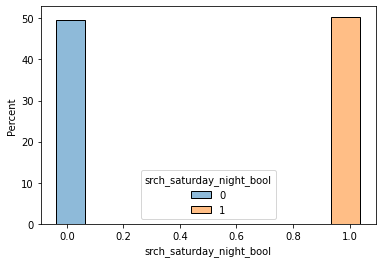

In [59]:


ax = sns.histplot(x = train_reduced['srch_saturday_night_bool'], hue=train_reduced['srch_saturday_night_bool'] ,
                  stat = 'percent', shrink =4,common_norm=True)


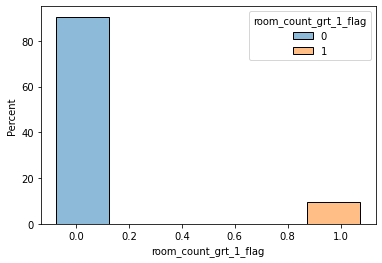

In [60]:
train_reduced['room_count_grt_1_flag'] = np.where(train_reduced['srch_room_count']> 1, 1, 0)

ax = sns.histplot(x = train_reduced['room_count_grt_1_flag'], hue=train_reduced['room_count_grt_1_flag'] ,
                  stat = 'percent', shrink =4,common_norm=True)

In [61]:
# df = train_reduced.loc[(train_reduced['gross_bookings_usd'] >= 0) & (train_reduced['gross_bookings_usd'] <= 1000)]
# sns.kdeplot(df['gross_bookings_usd'])
# plt.show()

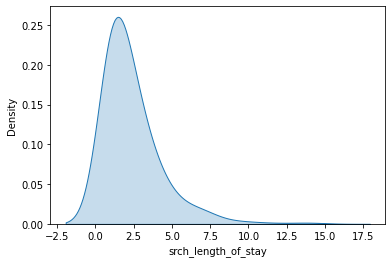

In [62]:
df = train_reduced.loc[(train_reduced['srch_length_of_stay'] >= 0) & (train_reduced['srch_length_of_stay'] <= 15)]
sns.kdeplot(df['srch_length_of_stay'], shade=True, bw_adjust=7)
plt.show()

In [63]:
train_reduced = train_reduced.loc[(train_reduced['random_bool'] == 0)]

<AxesSubplot:>

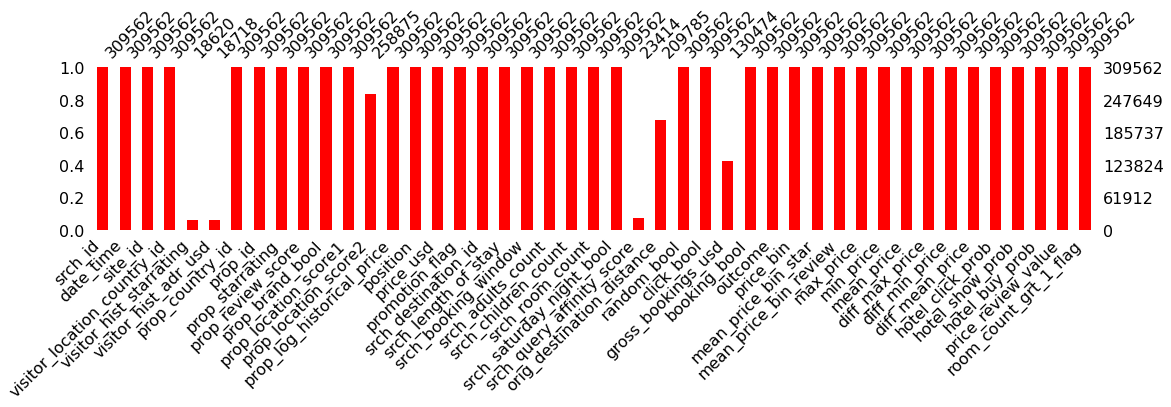

In [64]:

msn.bar(train_reduced,figsize=(18,3), color='red')

In [65]:
to_drop = ['srch_id','site_id', 'date_time', 'visitor_location_country_id', 'prop_country_id', 'prop_id', 'prop_brand_bool', 'orig_destination_distance', 'click_bool', 'room_count_grt_1_flag', 'random_bool', 'booking_bool', 'srch_destination_id', 'position', 'prop_location_score2'
          ,'gross_bookings_usd', 'price_usd', 'max_price','min_price', 'mean_price', 'mean_price_bin_review','mean_price_bin_star', 'price_bin' ] 

train1 = train_reduced.drop(to_drop,  axis=1)

<AxesSubplot:>

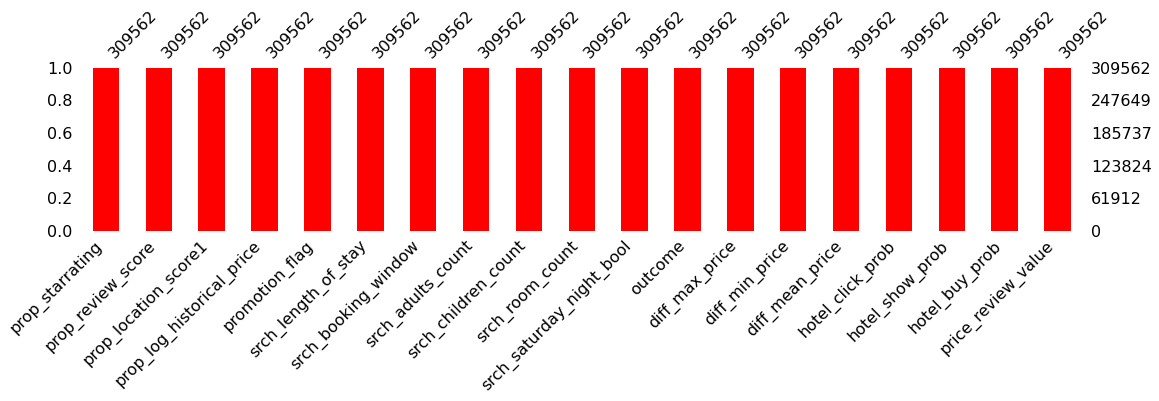

In [66]:
train1.replace([np.inf, -np.inf], 0, inplace=True)

train1=train1.dropna(axis=1,how="any")
msn.bar(train1,figsize=(18,3), color='red')

In [67]:
train1 = train1[['prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob','diff_max_price','diff_min_price','diff_mean_price','hotel_show_prob', 'prop_starrating', 'prop_review_score','price_review_value', 'outcome']]

In [68]:
#train1.reset_index()
X = train1.iloc[:, :-1].values
y = train1.iloc[:, -1].values

In [69]:
train1.head(20)



prop_starrating  prop_location_score1  prop_log_historical_price  \
outcome                                                                        
0       0               2.0                  1.61                       4.13   
        1               3.0                  2.08                       4.47   
        2               2.0                  3.30                       5.16   
        3               3.0                  2.20                       4.78   
        4               5.0                  4.29                       5.94   
        5               4.0                  3.61                       5.08   
        6               2.0                  2.64                       4.25   
        10              3.0                  2.40                       4.88   
        11              5.0                  4.96                       0.00   
        12              4.0                  3.53                       5.09   
        13              4.0                  4.20                       5.54   
        15              2.0                  2.48                       4.64   
        16              2.0                  4.17                       4.49   
        17              3.0                  3.61                       3.71   
        18              3.0                  4.08                       5.96   
        20              5.0                  4.42                       5.55   
        21              3.0                  2.20                       0.00   
        22              3.0                  3.37                       0.00   
        24              4.0                  5.91                       0.00   
        25              3.0                  4.42                       5.17   

            promotion_flag  srch_length_of_stay  srch_booking_window  \
outcome                                                                
0       0                1                    1                    0   
        1                0                    1                   12   
        2                0                    2                   17   
        3                0                    1                   22   
        4                0                    1                    4   
        5                0                    1                    7   
        6                0                    1                    1   
        10               0                    4                   79   
        11               0                    3                   66   
        12               0                    2                    7   
        13               0                    1                   96   
        15               0                    2                    0   
        16               1                    2                   36   
        17               0                    2                    7   
        18               0                    1                   19   
        20               1                    1                    9   
        21               0                    2                   10   
        22               1                    2                   42   
        24               0                    4                    1   
        25               0                    1                    2   

            srch_adults_count  srch_children_count  srch_room_count  \
outcome                                                               
0       0                   2                    0                1   
        1                   1                    0                1   
        2                   2                    0                1   
        3                   2                    0                1   
        4                   2                    0                1   
        5                   1                    0                1   
        6                   1                    0                1   
        10                 

In [70]:
models_list=[
    LogisticRegression(),
  #  Lasso(),
   # RandomForestClassifier(criterion='entropy', min_samples_leaf=60,
             #          min_samples_split=4, random_state=16),
    #GradientBoostingClassifier(),
    lgb.LGBMClassifier(),
   # LinearSVC(random_state=42, C=0.01),
    #xgb.XGBRegressor(objective="reg:linear", random_state=42)   
  #  xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.1), 
 #   xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.05), #better. 
  #  xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.01), 
    #  "multi:softprob"
]

In [71]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [72]:
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
import warnings
warnings.filterwarnings('ignore')

l=[]
for model in models_list:
    #clf=clf_models(model)
    print(model)
    fit_model=model.fit(X_train, y_train)
    score=model.score(X_test, y_test)
    print("model score: %.3f" % score)
    l.append([model,'clf', score, X_test, y_test])
    #print(clf)
    #scores = -1 * cross_val_score(clf, X, y,cv=5,scoring='neg_mean_absolute_error')
    #print("MAE scores:\n", scores.mean(), scores.sum(), scores.min())
    
#print(l[3][4])
#print(l[2][3])
#print(l[2][0])

LogisticRegression()
model score: 0.647
LGBMClassifier()
model score: 0.715


In [73]:
y_pred=l[1][0].predict(X_test)

print(y_pred)

y_pred[:5]

[1 0 0 ... 1 0 1]


array([1, 0, 0, 0, 0])

In [74]:
predictors = ['prop_starrating', 'prop_location_score1','prop_log_historical_price','promotion_flag','srch_length_of_stay','srch_booking_window','srch_adults_count','srch_children_count','srch_room_count','srch_saturday_night_bool', 'hotel_click_prob', 'hotel_buy_prob', 'diff_max_price','diff_min_price','diff_mean_price', 'hotel_show_prob', 'prop_starrating', 'prop_review_score','price_review_value']

In [75]:
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), l[1][0].feature_importances_), predictors), reverse=True))

Features sorted by their score:
[(351, 'diff_mean_price'), (340, 'hotel_click_prob'), (330, 'hotel_show_prob'), (274, 'diff_min_price'), (259, 'hotel_buy_prob'), (237, 'diff_max_price'), (229, 'prop_log_historical_price'), (188, 'prop_location_score1'), (187, 'price_review_value'), (158, 'srch_booking_window'), (103, 'prop_starrating'), (73, 'srch_length_of_stay'), (69, 'prop_review_score'), (59, 'srch_adults_count'), (51, 'srch_children_count'), (42, 'promotion_flag'), (37, 'srch_room_count'), (13, 'srch_saturday_night_bool'), (0, 'prop_starrating')]


In [76]:
from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(
    l[1][0], X_test, y_test, n_repeats=5, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=predictors)

Elapsed time to compute the importances: 20.096 seconds


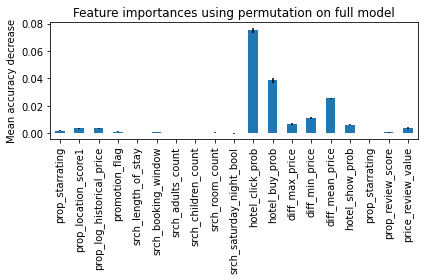

In [77]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [78]:
print(y_test)

[1 0 1 ... 1 1 1]


In [79]:
result = pd.DataFrame(y_test, columns=['actual'])
predicted= pd.DataFrame(y_pred, columns=['predicted'])

df = pd.DataFrame(X_test)



In [80]:
df['result'] = result
df['perdicted'] = predicted

In [81]:
df.to_csv('results1.csv') 

In [82]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,result,perdicted
0,2.0,2.83,4.79,0.0,1.0,10.0,2.0,0.0,1.0,1.0,...,0.260870,1.866667,-0.373333,0.423529,4.058824,2.0,3.5,0.957721,1,1
1,3.0,1.61,4.59,0.0,1.0,0.0,2.0,0.0,1.0,1.0,...,0.013889,0.431655,-0.568345,-0.190647,4.500000,3.0,4.5,1.089086,0,0
2,3.0,0.69,5.18,0.0,2.0,3.0,2.0,2.0,1.0,1.0,...,0.035714,0.080537,-0.651007,-0.302367,1.473684,3.0,4.5,1.094666,1,0
3,3.0,1.61,4.94,0.0,6.0,24.0,2.0,2.0,1.0,0.0,...,0.000000,3.148760,-0.388430,1.182569,4.636364,3.0,5.0,1.258937,0,0
4,3.0,0.69,0.00,0.0,1.0,6.0,2.0,0.0,1.0,1.0,...,0.033333,0.733906,-0.247714,0.179164,3.750000,3.0,3.0,0.740850,0,0
